In [1]:
from support_functions import *

pd.set_option('display.max_columns', None)

plt.style.use(['ggplot', 'seaborn-talk'])

C:\Users\claud\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### GRID_SEARCH
**The variable below, `RUN_GRIDSEARCH` is used in this notebook as a decision to run the sklearn `GridSearchCV` with given parameters. A model param/metrics dataframe will then be dumped into the directory to replace the current df.**

**This process is computationally expensive and takes a very long time. With `RUN_GRIDSEARCH` set to False, a GridSearch will not be run, but rather the found optimizations will be fitted and shown graphically.**

In [2]:
RUN_GRIDSEARCH = False

# Modeling Goals
- The aim of the competition is a plain `accuracy_score` for unlabeled data.
- From a financial perspective, the allocation of maintenance resources is vital, therefore correctly labeling the pumps which are *functional needs repair* and *non functional* can be considered the most important.

## Reload Data
Reload from processing notebook.

In [3]:
os.listdir('processed_data/')

['.ipynb_checkpoints',
 'cat_feature_names.jobjib',
 'num_feature_names.jobjib',
 'unlabeled_y_df.csv',
 'X_test_df.csv',
 'X_train_df.csv',
 'y_test_enc.csv',
 'y_train_enc.csv']

In [4]:
label_enc = load('dumps/label_enc.jobjib')
LABEL_NAMES = label_enc.classes_
LABEL_NAMES

array(['functional', 'functional needs repair', 'non functional'],
      dtype=object)

In [5]:
X_train = pd.read_csv('processed_data/X_train_df.csv', index_col=0)
X_test = pd.read_csv('processed_data/X_test_df.csv', index_col=0)
y_train = pd.read_csv('processed_data/y_train_enc.csv', 
                      index_col=0)['status_group']
y_test = pd.read_csv('processed_data/y_test_enc.csv', 
                     index_col=0)['status_group']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((44550, 138), (14850, 138), (44550,), (14850,))

In [6]:
REAL_TEST = pd.read_csv('processed_data/unlabeled_y_df.csv', index_col=0)
REAL_TEST.shape

(14850, 138)

# Modeling
In this notebook, we will be using a dummy-classifier and three predictive models.
- Random Forest Classifier
- K-Nearest Neighbors
- XGBoost Classifier

## Baseline - Dummy Classifier

In [7]:
# Set up baseline dummy-classifier which predicts 
# randomly based on the class distribution.
dummy_clf = DummyClassifier(random_state=RANDOM_STATE,
                            strategy='stratified')
dummy_clf.fit(X_train, y_train)

DummyClassifier(random_state=51, strategy='stratified')

********************************************************
*        Dummy Classifier Classification Report        *
********************************************************
                         precision    recall  f1-score   support

             functional       0.54      0.55      0.55      8065
functional needs repair       0.07      0.07      0.07      1079
         non functional       0.39      0.39      0.39      5706

               accuracy                           0.45     14850
              macro avg       0.34      0.34      0.34     14850
           weighted avg       0.45      0.45      0.45     14850



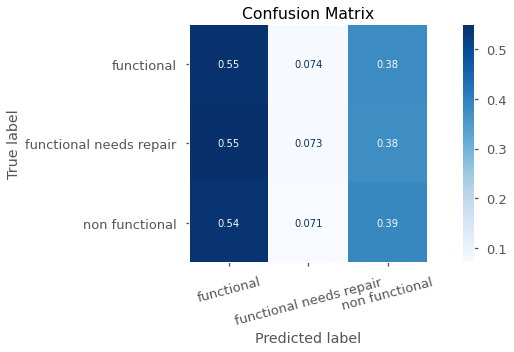

In [8]:
show_metrics(dummy_clf, X_test, y_test, 
             label='Dummy Classifier',
             target_names=LABEL_NAMES)

## Random Forest Classifier

### Vanilla Model

,Label,Timestamp,Elapsed Time (sec)
0,Start,2020-09-28 14:45:40.243727,0.000000
1,Stop,2020-09-28 14:45:51.334913,11.091186


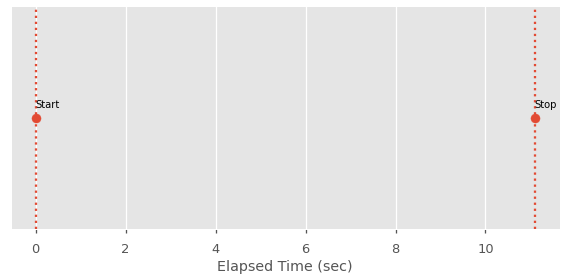

In [9]:
watch = Stopwatch()

# Starting with no parameter-tuning.
forest = RandomForestClassifier(random_state=RANDOM_STATE)
forest.fit(X_train, y_train)

watch.stop()
watch.display_laps()

************************************************************************
*        Vanilla Random Forest Classifier Classification Report        *
************************************************************************
                         precision    recall  f1-score   support

             functional       0.81      0.89      0.85      8065
functional needs repair       0.54      0.35      0.43      1079
         non functional       0.84      0.78      0.81      5706

               accuracy                           0.81     14850
              macro avg       0.73      0.67      0.69     14850
           weighted avg       0.80      0.81      0.80     14850



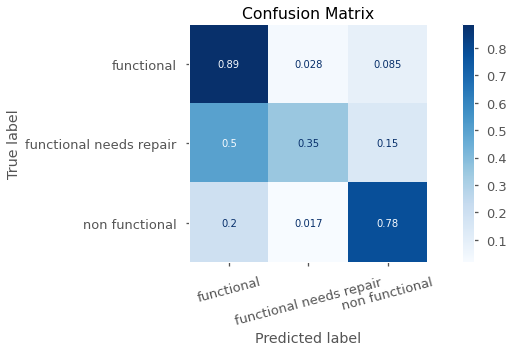

In [10]:
show_metrics(forest, X_test, y_test, 
             label='Vanilla Random Forest Classifier',
             target_names=LABEL_NAMES)

Having a vanilla Random Forest score `0.81` accuracy is pretty impressive. I feel that this might be a great model-type for this problem because of the number of categorical features and the robust-quality of a Forest. 

In [11]:
# Set up feature-importance df to plot.
feat_imp_dct = dict(
    feature = X_train.columns,
    importance = forest.feature_importances_
)
feat_imp = pd.DataFrame(feat_imp_dct)

feat_imp.sort_values('importance', ascending=False, inplace=True)
feat_imp.head(10)

,feature,importance
2,longitude,0.139324
3,latitude,0.139246
110,quantity_dry,0.078067
1,gps_height,0.068331
6,years_old,0.053079
5,population,0.047388
136,waterpoint_type_group_other,0.027519
111,quantity_enough,0.024025
0,amount_tsh,0.019767
76,extraction_type_group_other,0.017666


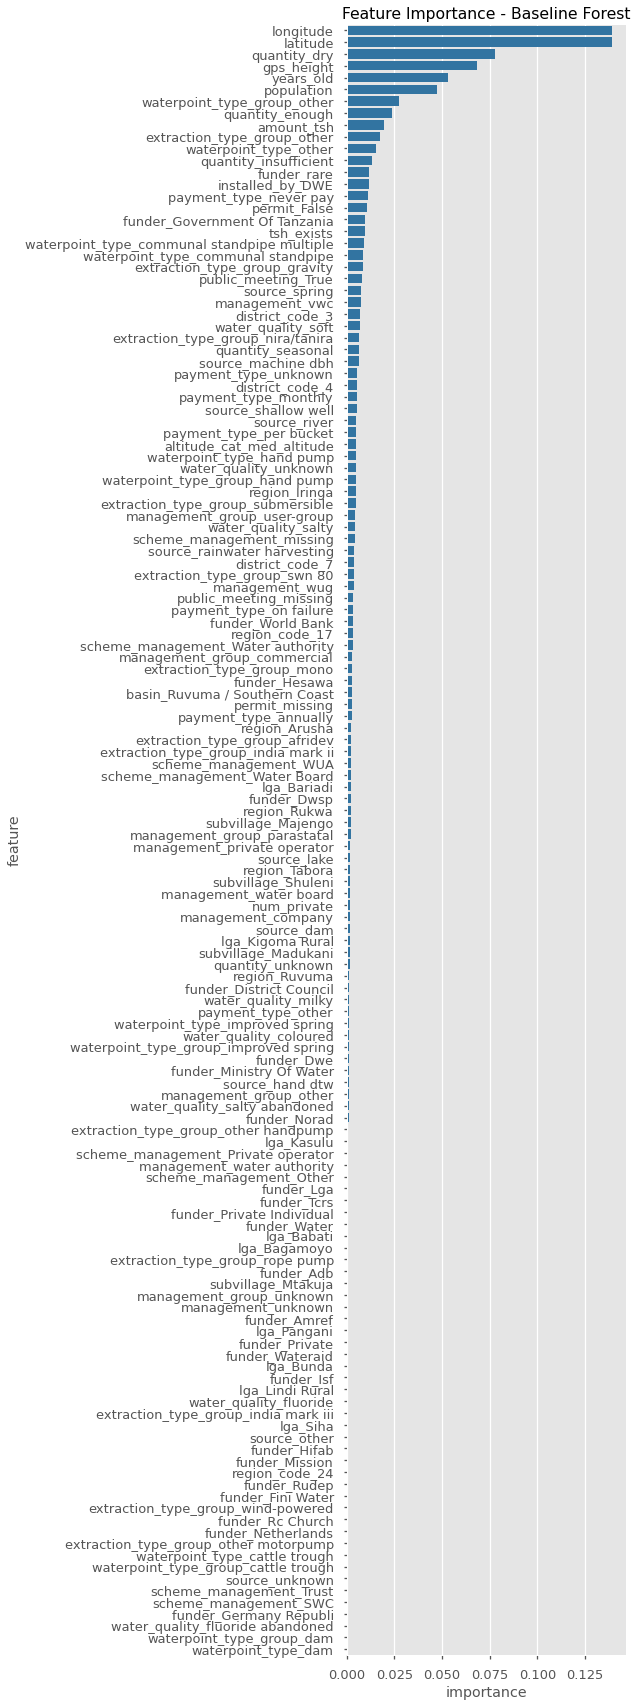

In [12]:
# Plot feature importances from vanilla model.
fig, ax = plt.subplots(figsize=(5,30))
sns.barplot(x='importance', y='feature', data=feat_imp, orient='h',
            color=COLOR, ax=ax)
ax.set(title='Feature Importance - Baseline Forest');

Interestingly, some of the top features are *locational* (`longitude` / `latitude` / `gps_height`).

### Forest GridSearch
For each model type, we will try to tune some parameters to optimize for different metrics.

In [13]:
FOREST_FNAME = 'forest_df.jobjib'

****************************************************
*        RFC-accuracy Classification Report        *
****************************************************
                         precision    recall  f1-score   support

             functional       0.79      0.93      0.85      8065
functional needs repair       0.68      0.25      0.37      1079
         non functional       0.87      0.75      0.80      5706

               accuracy                           0.81     14850
              macro avg       0.78      0.64      0.67     14850
           weighted avg       0.81      0.81      0.80     14850



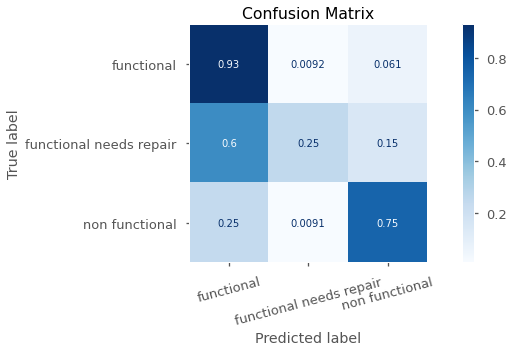

****************************************************
*        RFC-f1_macro Classification Report        *
****************************************************
                         precision    recall  f1-score   support

             functional       0.81      0.88      0.85      8065
functional needs repair       0.53      0.35      0.42      1079
         non functional       0.84      0.78      0.81      5706

               accuracy                           0.81     14850
              macro avg       0.73      0.67      0.69     14850
           weighted avg       0.80      0.81      0.80     14850



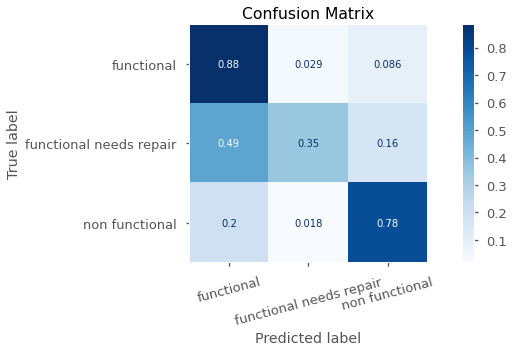

***********************************************************
*        RFC-precision_macro Classification Report        *
***********************************************************
                         precision    recall  f1-score   support

             functional       0.77      0.93      0.84      8065
functional needs repair       0.71      0.22      0.34      1079
         non functional       0.87      0.72      0.79      5706

               accuracy                           0.80     14850
              macro avg       0.78      0.63      0.66     14850
           weighted avg       0.80      0.80      0.79     14850



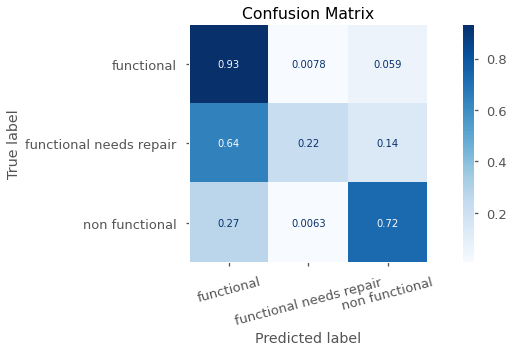

********************************************************
*        RFC-recall_macro Classification Report        *
********************************************************
                         precision    recall  f1-score   support

             functional       0.81      0.88      0.85      8065
functional needs repair       0.53      0.36      0.43      1079
         non functional       0.84      0.79      0.81      5706

               accuracy                           0.81     14850
              macro avg       0.73      0.67      0.69     14850
           weighted avg       0.80      0.81      0.80     14850



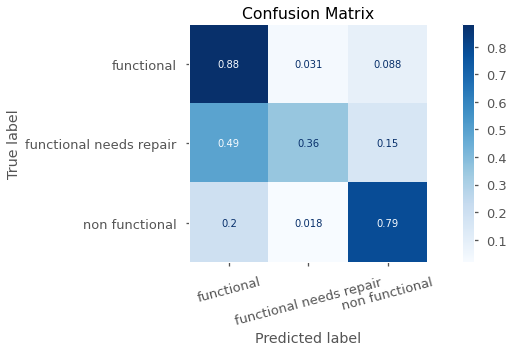

,Label,Timestamp,Elapsed Time (sec)
0,Start,2020-09-28 14:45:55.042318,0.000000
1,RFC-accuracy,2020-09-28 14:46:09.421004,14.378686
2,RFC-f1_macro,2020-09-28 14:46:20.982670,25.940352
3,RFC-precision_macro,2020-09-28 14:46:33.911827,38.869509
4,RFC-recall_macro,2020-09-28 14:46:45.479027,50.436709


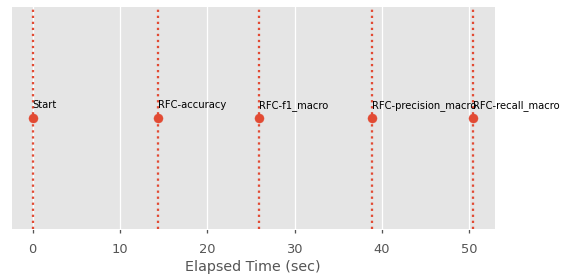

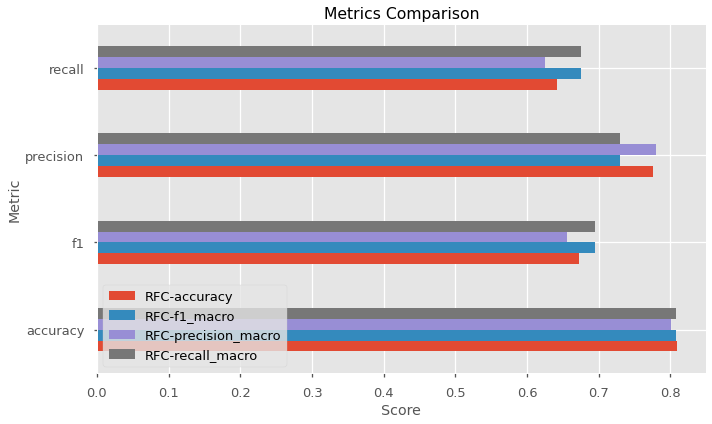

,model_label,best_params,accuracy,f1,precision,recall
0,RFC-accuracy,"{'bootstrap': False, 'criterion': 'entropy', '...",0.808754,0.672206,0.775913,0.641244
1,RFC-f1_macro,"{'bootstrap': True, 'criterion': 'gini', 'min_...",0.807407,0.695122,0.729211,0.675047
2,RFC-precision_macro,"{'bootstrap': False, 'criterion': 'entropy', '...",0.800943,0.656252,0.780531,0.625529
3,RFC-recall_macro,"{'bootstrap': True, 'criterion': 'gini', 'min_...",0.807407,0.695122,0.729211,0.675047


In [14]:
# SEE NOTE ON `RUN_GRIDSEARCH`.
if RUN_GRIDSEARCH:
    forest_params = {
        'criterion': ['gini', 'entropy'],
        'min_samples_leaf': [1, 3, 5],
        'bootstrap': [True, False]
    }
    
    forest_df = gridsearch_model(RandomForestClassifier,
                                 'RFC',
                                 forest_params,
                                 X_train, X_test, y_train, y_test, 
                                 target_names=LABEL_NAMES,
                                 scoring_metrics=['accuracy', 'f1', 
                                                  'precision', 'recall'],
                                 multiclass_default_average='macro')
    
    dump(forest_df, f'models/{FOREST_FNAME}')
    
# Else, load in data.
elif FOREST_FNAME in os.listdir('models/'):
    forest_df = load(f'models/{FOREST_FNAME}')
    show_metrics_for_df(forest_df,
                        RandomForestClassifier,
                        X_train,
                        X_test,
                        y_train,
                        y_test,
                        target_names=LABEL_NAMES)
    
plot_comparisons(forest_df)
forest_df

The model optimized for accuracy is very good with a 0.809 `accuracy`, however it leaves some to be desired with its low `recall_macro`.
> Recall with a **macro-weight** is a harsher metric than "weighted" because it finds a balance between the categories equally, rather than making it more important to correctly identify the more-common categories.

## K-Neighbors Classifier

### Vanilla Model

,Label,Timestamp,Elapsed Time (sec)
0,Start,2020-09-28 14:46:45.813688,0.000000
1,Stop,2020-09-28 14:46:49.869831,4.056143


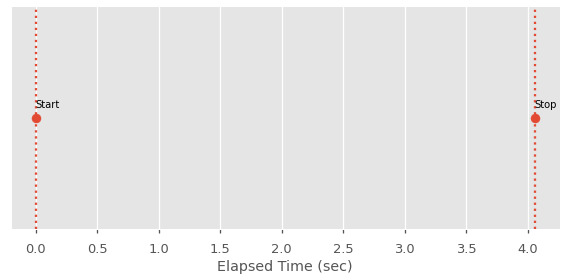

In [15]:
watch = Stopwatch()

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

watch.stop()
watch.display_laps()

******************************************************
*        KNN Classifier Classification Report        *
******************************************************
                         precision    recall  f1-score   support

             functional       0.77      0.86      0.81      8065
functional needs repair       0.48      0.30      0.37      1079
         non functional       0.80      0.72      0.75      5706

               accuracy                           0.77     14850
              macro avg       0.68      0.63      0.65     14850
           weighted avg       0.76      0.77      0.76     14850



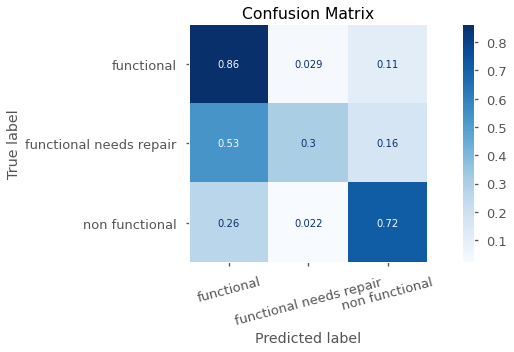

In [16]:
show_metrics(knn, X_test, y_test, 
             label='KNN Classifier',
             target_names=LABEL_NAMES)

### KNN GridSearch

In [17]:
KNN_FNAME = 'knn_df.jobjib'

****************************************************
*        KNN-accuracy Classification Report        *
****************************************************
                         precision    recall  f1-score   support

             functional       0.78      0.85      0.81      8065
functional needs repair       0.46      0.31      0.37      1079
         non functional       0.79      0.73      0.76      5706

               accuracy                           0.77     14850
              macro avg       0.68      0.63      0.65     14850
           weighted avg       0.76      0.77      0.76     14850



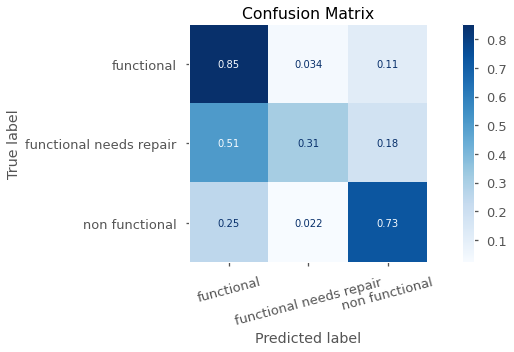

****************************************************
*        KNN-f1_macro Classification Report        *
****************************************************
                         precision    recall  f1-score   support

             functional       0.78      0.85      0.81      8065
functional needs repair       0.46      0.31      0.37      1079
         non functional       0.79      0.73      0.76      5706

               accuracy                           0.77     14850
              macro avg       0.68      0.63      0.65     14850
           weighted avg       0.76      0.77      0.76     14850



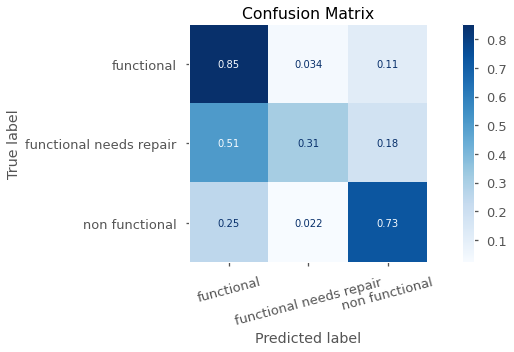

***********************************************************
*        KNN-precision_macro Classification Report        *
***********************************************************
                         precision    recall  f1-score   support

             functional       0.76      0.87      0.81      8065
functional needs repair       0.56      0.28      0.37      1079
         non functional       0.78      0.69      0.73      5706

               accuracy                           0.76     14850
              macro avg       0.70      0.61      0.64     14850
           weighted avg       0.75      0.76      0.75     14850



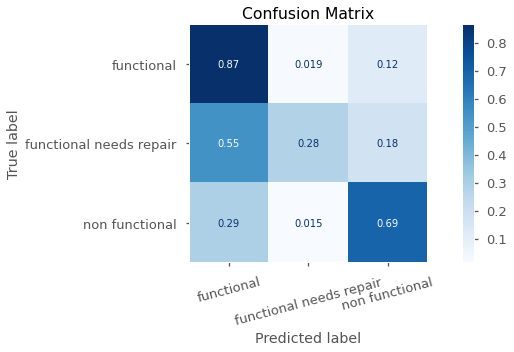

********************************************************
*        KNN-recall_macro Classification Report        *
********************************************************
                         precision    recall  f1-score   support

             functional       0.78      0.85      0.81      8065
functional needs repair       0.46      0.31      0.37      1079
         non functional       0.79      0.73      0.76      5706

               accuracy                           0.77     14850
              macro avg       0.68      0.63      0.65     14850
           weighted avg       0.76      0.77      0.76     14850



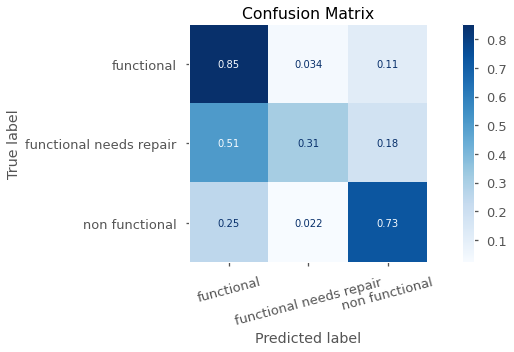

,Label,Timestamp,Elapsed Time (sec)
0,Start,2020-09-28 14:48:57.803111,0.000000
1,KNN-accuracy,2020-09-28 14:50:48.016387,110.213276
2,KNN-f1_macro,2020-09-28 14:52:47.386257,229.583146
3,KNN-precision_macro,2020-09-28 14:55:10.994551,373.191440
4,KNN-recall_macro,2020-09-28 14:57:03.278410,485.475299


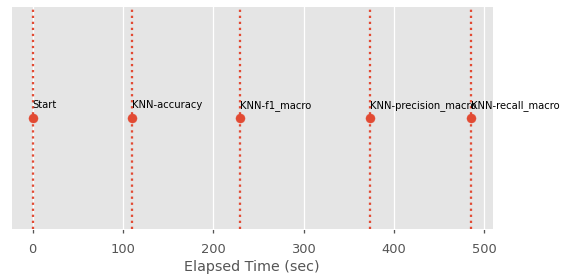

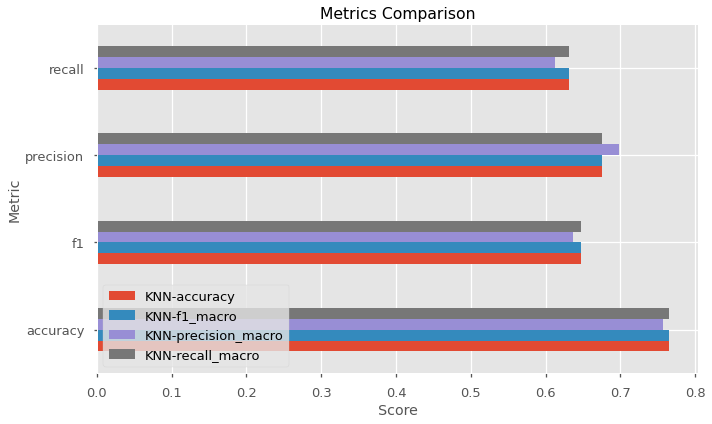

,model_label,best_params,accuracy,f1,precision,recall
0,KNN-accuracy,{'n_neighbors': 3},0.765589,0.647659,0.675512,0.631222
1,KNN-f1_macro,{'n_neighbors': 3},0.765589,0.647659,0.675512,0.631222
2,KNN-precision_macro,{'n_neighbors': 9},0.756566,0.637257,0.697740,0.612245
3,KNN-recall_macro,{'n_neighbors': 3},0.765589,0.647659,0.675512,0.631222


In [18]:
if RUN_GRIDSEARCH:
    knn_params = {
        'n_neighbors': [3, 5, 7, 9]
    }

    knn_df = gridsearch_model(KNeighborsClassifier,
                              'KNN',
                              knn_params,
                              X_train, X_test, y_train, y_test, 
                              target_names=LABEL_NAMES,
                              scoring_metrics=['accuracy', 'f1', 
                                               'precision', 'recall'],
                              multiclass_default_average='macro')
    
    dump(knn_df, f'models/{KNN_FNAME}')
    
elif KNN_FNAME in os.listdir('models/'):
    knn_df = load(f'models/{KNN_FNAME}')
    show_metrics_for_df(knn_df,
                        KNeighborsClassifier,
                        X_train,
                        X_test,
                        y_train,
                        y_test,
                        target_names=LABEL_NAMES)
    
plot_comparisons(knn_df)
knn_df

These models aren't showing as much accuracy as the Random Forests, nor do they seem to be better at finding the minority class `functional needs repair`.

## XGBoost

### Vanilla Model

,Label,Timestamp,Elapsed Time (sec)
0,Start,2020-09-28 14:57:03.595037,0.00000
1,Stop,2020-09-28 14:57:41.468967,37.87393


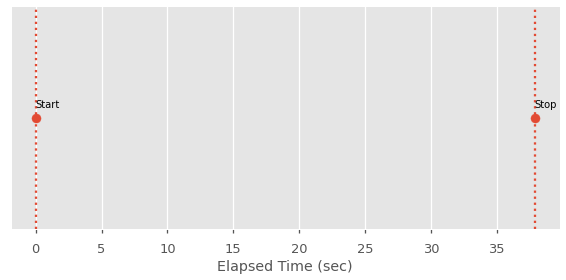

In [19]:
watch = Stopwatch()

xgb = XGBClassifier(random_state=RANDOM_STATE)
xgb.fit(X_train, y_train)

watch.stop()
watch.display_laps()

*************************************************************
*        Vanilla XGBClassifier Classification Report        *
*************************************************************
                         precision    recall  f1-score   support

             functional       0.71      0.93      0.81      8065
functional needs repair       0.62      0.12      0.21      1079
         non functional       0.84      0.61      0.70      5706

               accuracy                           0.75     14850
              macro avg       0.72      0.55      0.57     14850
           weighted avg       0.76      0.75      0.72     14850



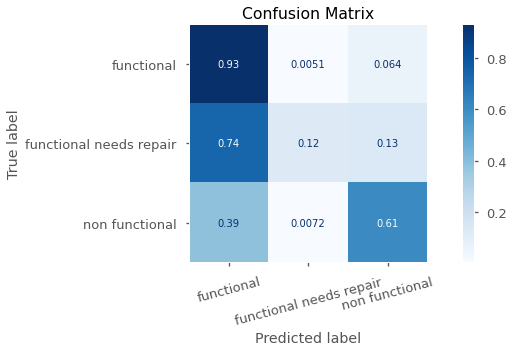

In [20]:
show_metrics(xgb, X_test, y_test, 
             label='Vanilla XGBClassifier',
             target_names=LABEL_NAMES)

### XGB GridSearch

In [21]:
XGB_FNAME = 'xgb_df.jobjib'

****************************************************
*        xgb-accuracy Classification Report        *
****************************************************
                         precision    recall  f1-score   support

             functional       0.77      0.92      0.84      8065
functional needs repair       0.67      0.23      0.34      1079
         non functional       0.86      0.73      0.79      5706

               accuracy                           0.80     14850
              macro avg       0.77      0.63      0.66     14850
           weighted avg       0.80      0.80      0.79     14850



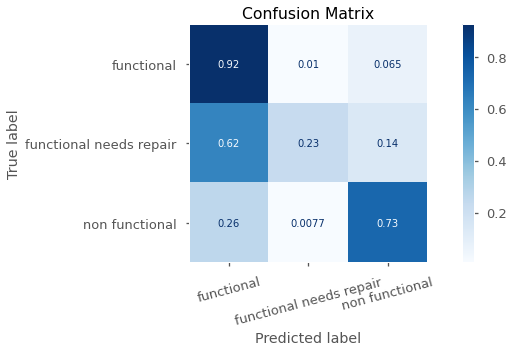

****************************************************
*        xgb-f1_macro Classification Report        *
****************************************************
                         precision    recall  f1-score   support

             functional       0.77      0.92      0.84      8065
functional needs repair       0.67      0.23      0.34      1079
         non functional       0.86      0.73      0.79      5706

               accuracy                           0.80     14850
              macro avg       0.77      0.63      0.66     14850
           weighted avg       0.80      0.80      0.79     14850



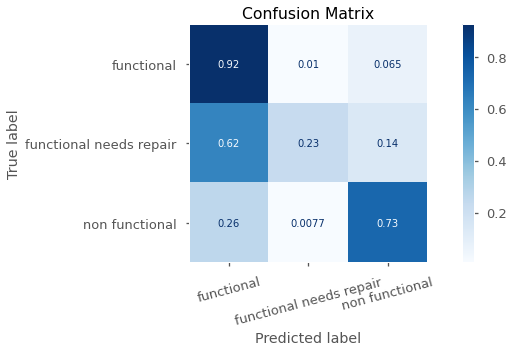

***********************************************************
*        xgb-precision_macro Classification Report        *
***********************************************************
                         precision    recall  f1-score   support

             functional       0.77      0.92      0.84      8065
functional needs repair       0.67      0.23      0.34      1079
         non functional       0.86      0.73      0.79      5706

               accuracy                           0.80     14850
              macro avg       0.77      0.63      0.66     14850
           weighted avg       0.80      0.80      0.79     14850



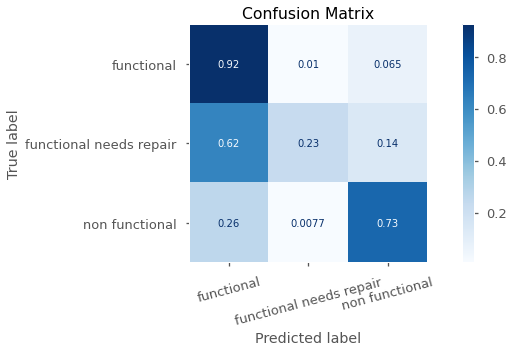

********************************************************
*        xgb-recall_macro Classification Report        *
********************************************************
                         precision    recall  f1-score   support

             functional       0.77      0.92      0.84      8065
functional needs repair       0.67      0.23      0.34      1079
         non functional       0.86      0.73      0.79      5706

               accuracy                           0.80     14850
              macro avg       0.77      0.63      0.66     14850
           weighted avg       0.80      0.80      0.79     14850



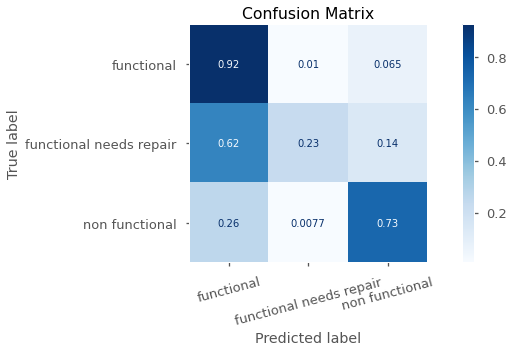

,Label,Timestamp,Elapsed Time (sec)
0,Start,2020-09-28 14:57:42.147802,0.000000
1,xgb-accuracy,2020-09-28 14:59:27.400511,105.252709
2,xgb-f1_macro,2020-09-28 15:01:11.449683,209.301881
3,xgb-precision_macro,2020-09-28 15:02:53.952604,311.804802
4,xgb-recall_macro,2020-09-28 15:04:47.192863,425.045061


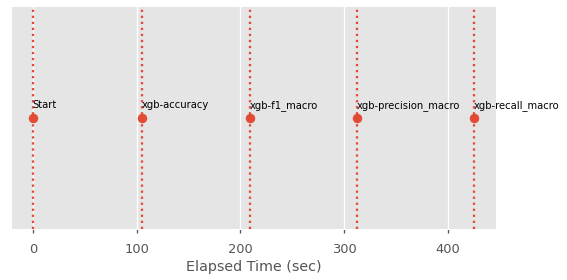

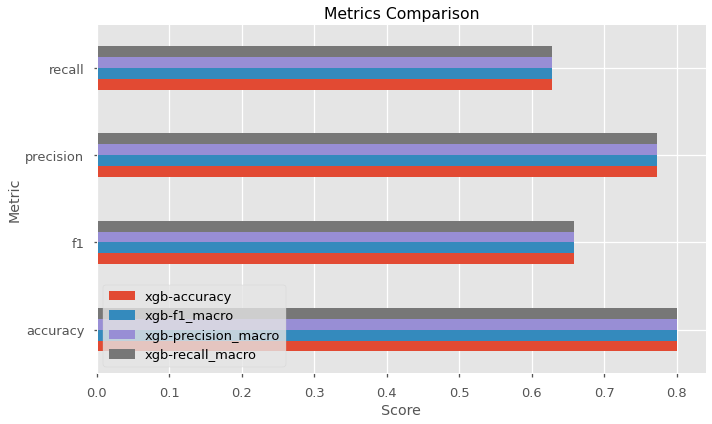

,model_label,best_params,accuracy,f1,precision,recall
0,xgb-accuracy,"{'learning_rate': 0.1, 'max_depth': 9}",0.8,0.657927,0.772328,0.627689
1,xgb-f1_macro,"{'learning_rate': 0.1, 'max_depth': 9}",0.8,0.657927,0.772328,0.627689
2,xgb-precision_macro,"{'learning_rate': 0.1, 'max_depth': 9}",0.8,0.657927,0.772328,0.627689
3,xgb-recall_macro,"{'learning_rate': 0.1, 'max_depth': 9}",0.8,0.657927,0.772328,0.627689


In [22]:
if RUN_GRIDSEARCH:
    xgb_params = {
        'max_depth': [3, 5, 7]
    }

    xgb_df = gridsearch_model(XGBClassifier,
                              'XGB',
                              xgb_params,
                              X_train, X_test, y_train, y_test, 
                              target_names=LABEL_NAMES,
                              scoring_metrics=['accuracy', 'f1', 
                                               'precision', 'recall'],
                              multiclass_default_average='macro')
    
    dump(knn_df, f'models/{XGB_FNAME}')
    
elif XGB_FNAME in os.listdir('models/'):
    xgb_df = load(f'models/{XGB_FNAME}')
    show_metrics_for_df(xgb_df,
                        XGBClassifier,
                        X_train,
                        X_test,
                        y_train,
                        y_test,
                        target_names=LABEL_NAMES)
    
plot_comparisons(xgb_df)
xgb_df

The XGB models are tending to prioritize over-guessing the most common target variable - `functional`.

# Class Imbalance: SMOTE-NC
There are certainly some decent results, but a more balanced training set might help the models predict the minority classes.

- **SMOTENC** is a version of *SMOTE* which can handle one-hot-encoded columns by indicating which columns to treat as categorical.
- It will then create new data points (synthetically) to train on with hopes to get better modeling results.

In [23]:
# Loading columns from processing notebook.
categorical_columns = load('processed_data/cat_feature_names.jobjib')
numerical_columns = load('processed_data/num_feature_names.jobjib')

print('Num:', len(numerical_columns),' Cat:', len(categorical_columns))

Num: 58  Cat: 80


In [24]:
# Get column indexes which are categorical.
cat_col_idxs = np.array([list(X_train.columns).index(c) 
                         for c in categorical_columns])

# Use SMOTENC for continuous and categorical columns.
smote = SMOTENC(random_state=RANDOM_STATE, 
                categorical_features=cat_col_idxs)
smote

SMOTENC(categorical_features=array([ 58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137]),
        random_state=51)

In [25]:
# Synthesize training data to redistribute target classes.
print('Original Class Distribution:')
print(y_train.value_counts(normalize=True))

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print('Resampled Distribution:')
print(pd.Series(y_train_res).value_counts(normalize=True))

Original Class Distribution:
0    0.543075
2    0.384242
1    0.072682
Name: status_group, dtype: float64
Resampled Distribution:
2    0.333333
1    0.333333
0    0.333333
Name: status_group, dtype: float64


## Fit re-sampled data.

rfc
knn
xgb


,Label,Timestamp,Elapsed Time (sec)
0,Start,2020-09-28 15:07:33.293454,0.000000
1,rfc,2020-09-28 15:07:56.751763,23.458309
2,knn,2020-09-28 15:08:07.544731,34.251277
3,xgb,2020-09-28 15:10:49.518035,196.224581


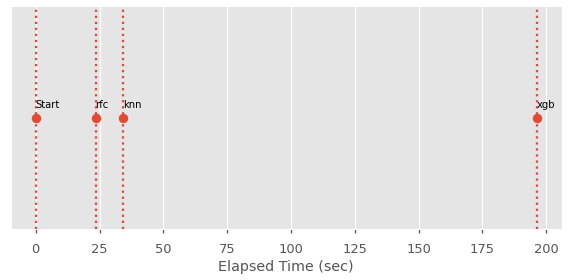

[(RandomForestClassifier(bootstrap=False, criterion='entropy', min_samples_leaf=3),
  'rfc'),
 (KNeighborsClassifier(n_neighbors=3), 'knn'),
 (XGBClassifier(max_depth=9, objective='multi:softprob'), 'xgb')]

In [26]:
# Get best accuracy model-params for each model type.
best_params_df_lst = [
    (RandomForestClassifier, forest_df, 'rfc'),
    (KNeighborsClassifier, knn_df, 'knn'),
    (XGBClassifier, xgb_df, 'xgb')
]

# Instantiate each model with its best accuracy params.
watch = Stopwatch()

models = []
for model, df, name in best_params_df_lst:
    params = df.iloc[0]['best_params']  # accuracy
    
    # Fit with synthesized data.
    m = model(**params).fit(X_train_res, y_train_res)
    models.append((m, name))
    
    print(name)
    watch.lap(label=name)
    
watch.stop()
watch.display_laps(show_stop=False)

models

*******************************************
*        rfc Classification Report        *
*******************************************
                         precision    recall  f1-score   support

             functional       0.83      0.81      0.82      8065
functional needs repair       0.34      0.56      0.42      1079
         non functional       0.84      0.76      0.80      5706

               accuracy                           0.77     14850
              macro avg       0.67      0.71      0.68     14850
           weighted avg       0.80      0.77      0.78     14850



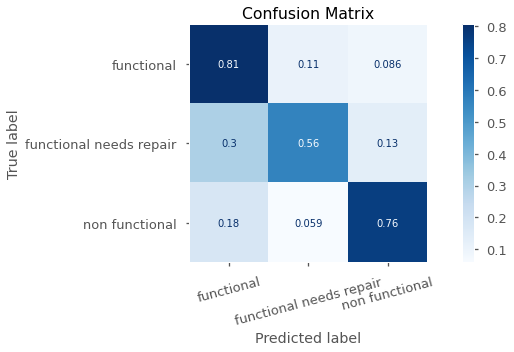

*******************************************
*        knn Classification Report        *
*******************************************
                         precision    recall  f1-score   support

             functional       0.80      0.78      0.79      8065
functional needs repair       0.33      0.45      0.38      1079
         non functional       0.77      0.75      0.76      5706

               accuracy                           0.74     14850
              macro avg       0.63      0.66      0.64     14850
           weighted avg       0.75      0.74      0.75     14850



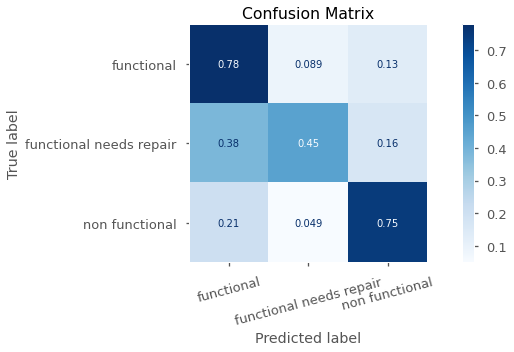

*******************************************
*        xgb Classification Report        *
*******************************************
                         precision    recall  f1-score   support

             functional       0.83      0.77      0.80      8065
functional needs repair       0.29      0.62      0.40      1079
         non functional       0.84      0.73      0.78      5706

               accuracy                           0.75     14850
              macro avg       0.65      0.71      0.66     14850
           weighted avg       0.79      0.75      0.76     14850



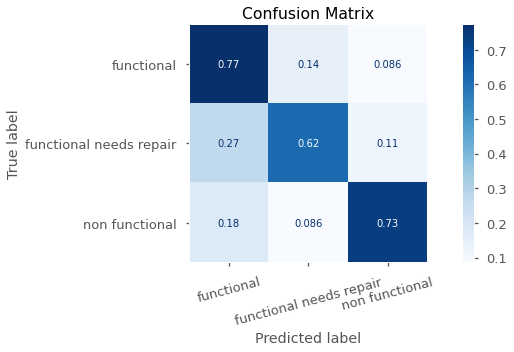

In [27]:
# Evaluate performance.
for model, name in models:
    show_metrics(model, X_test, y_test, 
                 label=name,
                 target_names=LABEL_NAMES)